In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [70]:
white_wine_trans = pd.read_csv('transformed_wine_data/white_wine_trans.csv')
red_wine_trans = pd.read_csv('transformed_wine_data/red_wine_trans.csv')

In [71]:
X_white = white_wine_trans.drop(['quality_label', 'quality', 'type'], axis = 1)
y_white = white_wine_trans['quality_label']

X_red = red_wine_trans.drop(['quality_label', 'quality', 'type'], axis = 1)
y_red = red_wine_trans['quality_label']

<h3> K Nearest Neighbors approach </h3>

<h3> Red Wine </h3>

In [72]:
# Working with red wine data
X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.3, random_state=101)

In [73]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [74]:
knn_model = KNeighborsClassifier(n_neighbors=1)         # Try with k = 1 first.

In [75]:
# Train model
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [76]:
y_pred = knn_model.predict(scaled_X_test)

In [77]:
accuracy_score(y_test,y_pred)

0.6020833333333333

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.14      0.20      0.17         5
         low       0.29      0.17      0.21        24
lower_middle       0.72      0.69      0.70       208
      middle       0.56      0.58      0.57       180
upper_middle       0.50      0.57      0.53        63

    accuracy                           0.60       480
   macro avg       0.44      0.44      0.44       480
weighted avg       0.60      0.60      0.60       480



Surprisingly, we get an improvement over logistic regression with both the accuracy and f1 scores.

<h3> Elbow Method for Choosing Reasonable K Values </h3>

In [79]:
train_error_rates = []
test_error_rates = []


for k in range(1,51):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_train = knn_model.predict(scaled_X_train)
    y_pred_test = knn_model.predict(scaled_X_test)
    
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test,y_pred_test)

    train_error_rates.append(train_error)
    test_error_rates.append(test_error)

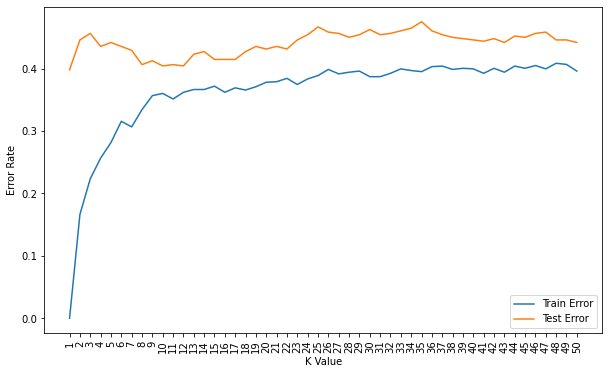

In [80]:
plt.figure(figsize=(10,6))
plt.plot(range(1,51),train_error_rates,label='Train Error')
plt.plot(range(1,51),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")
plt.xticks (ticks = range(1,51), labels = range(1,51))
plt.xticks(rotation = 90)
plt.show()

Baffling graphs. Error actually increases as we increase the K value.

<h5> Try Cross Validation Grid Search together with sklearn pipeline </h3>

In [81]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [82]:
operations = [('scaler', scaler), ('knn', knn)]

In [83]:
pipe = Pipeline(operations)

In [84]:
k_values = list(range(2,21))        # k = 1 overfits. So try from k = 2 onwards.

In [85]:
param_grid = {'knn__n_neighbors': k_values}

# knn = the operation that the parameters refer to 
# "n_neighbors" following __ = the parameter name (specific to the operation, in this case, knn)
# k_values = actual parameters

In [86]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [87]:
full_cv_classifier.fit(scaled_X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='accuracy')

In [88]:
full_cv_classifier.best_params_

{'knn__n_neighbors': 11}

In [91]:
preds = full_cv_classifier.predict(scaled_X_test)

In [92]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        high       0.00      0.00      0.00         5
         low       0.25      0.04      0.07        24
lower_middle       0.70      0.70      0.70       208
      middle       0.55      0.64      0.59       180
upper_middle       0.40      0.35      0.37        63

    accuracy                           0.59       480
   macro avg       0.38      0.35      0.35       480
weighted avg       0.57      0.59      0.58       480



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN – Red Wine: <br> <br>

Accuracy: 59% <br>
f1 macro avg: 35%

<h3> White wine </h3>

In [93]:
# Working with white wine data
X_train, X_test, y_train, y_test = train_test_split(X_white, y_white, test_size=0.3, random_state=101)


In [94]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [95]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(scaled_X_train,y_train)
y_pred = knn_model.predict(scaled_X_test)

In [96]:
accuracy_score(y_test,y_pred)

0.6006802721088436

In [97]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.57      0.45      0.51        55
         low       0.34      0.25      0.29        60
lower_middle       0.60      0.63      0.61       438
      middle       0.64      0.63      0.64       666
upper_middle       0.55      0.59      0.57       251

    accuracy                           0.60      1470
   macro avg       0.54      0.51      0.52      1470
weighted avg       0.60      0.60      0.60      1470



Again, interestingly enough, the scores are higher across the board compared to logistic regression

<h3> Elbow Method for Choosing Reasonable K Values </h3>

In [98]:
train_error_rates = []
test_error_rates = []


for k in range(1,51):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_train = knn_model.predict(scaled_X_train)
    y_pred_test = knn_model.predict(scaled_X_test)
    
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test,y_pred_test)

    train_error_rates.append(train_error)
    test_error_rates.append(test_error)
    


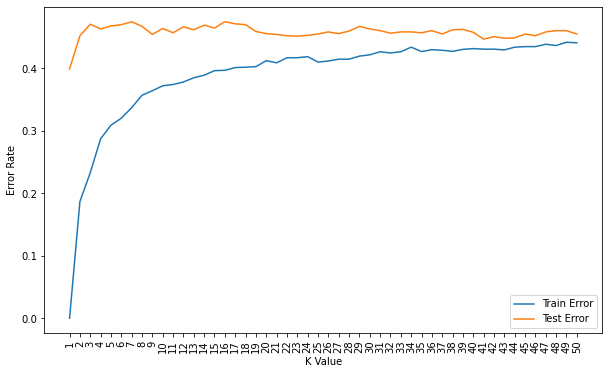

In [99]:
plt.figure(figsize=(10,6))
plt.plot(range(1,51),train_error_rates,label='Train Error')
plt.plot(range(1,51),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")
plt.xticks (ticks = range(1,51), labels = range(1,51))
plt.xticks(rotation = 90)
plt.show()

Again, quite bafflingly, the error rate INCREASES with increasing K value

<h5> Try Cross Validation Grid Search together with sklearn pipeline </h3>

In [100]:
scaler = StandardScaler()
knn = KNeighborsClassifier()
operations = [('scaler', scaler), ('knn', knn)]

pipe = Pipeline(operations)


k_values = list(range(2,51))
param_grid = {'knn__n_neighbors': k_values}

# knn = the operation that the parameters refer to 
# "n_neighbors" following __ = the parameter name (specific to the operation, in this case, knn)
# k_values = actual parameters


In [101]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')
full_cv_classifier.fit(scaled_X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, 31, ...]},
             scoring='accuracy')

In [102]:
full_cv_classifier.best_params_

{'knn__n_neighbors': 31}

In [105]:
preds = full_cv_classifier.predict(scaled_X_test)
print (classification_report (y_test, preds))

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        55
         low       0.00      0.00      0.00        60
lower_middle       0.56      0.58      0.57       438
      middle       0.54      0.69      0.61       666
upper_middle       0.46      0.30      0.36       251

    accuracy                           0.54      1470
   macro avg       0.31      0.32      0.31      1470
weighted avg       0.49      0.54      0.51      1470



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN White Wine <br> <br>

accuracy: 54% <br>
f1 macro avg: 31 %

<h3> KNN with SMOTE </h3>

<h3> White Wine </h3>

In [131]:
# Working with white wine data
X_train, X_test, y_train, y_test = train_test_split(X_white, y_white, test_size=0.3, random_state=101)

In [132]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [133]:
y_train.value_counts()

middle          1532
lower_middle    1019
upper_middle     629
high             125
low              123
Name: quality_label, dtype: int64

In [134]:
under_strategy_white = {'middle': 1000, 'lower_middle': 1000, 'upper_middle': 629, 'low': 123, 'high': 125}
over_strategy_white = {'middle': 1000, 'lower_middle': 1000, 'upper_middle': 800, 'low': 400, 'high': 400}

under_white = RandomUnderSampler(sampling_strategy = under_strategy_white)
over_white = SMOTE (sampling_strategy = over_strategy_white)

scaled_X_train, y_train = under_white.fit_resample(scaled_X_train, y_train)
scaled_X_train, y_train = over_white.fit_resample(scaled_X_train, y_train)

In [135]:
y_train.value_counts()

lower_middle    1000
middle          1000
upper_middle     800
high             400
low              400
Name: quality_label, dtype: int64

In [136]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(scaled_X_train,y_train)
y_pred = knn_model.predict(scaled_X_test)

In [137]:
accuracy_score(y_test,y_pred)

0.5741496598639456

In [138]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.39      0.53      0.45        55
         low       0.27      0.32      0.29        60
lower_middle       0.59      0.67      0.63       438
      middle       0.67      0.53      0.59       666
upper_middle       0.51      0.61      0.55       251

    accuracy                           0.57      1470
   macro avg       0.48      0.53      0.50      1470
weighted avg       0.59      0.57      0.58      1470



In [139]:
scaler = StandardScaler()
knn = KNeighborsClassifier()
operations = [('scaler', scaler), ('knn', knn)]

pipe = Pipeline(operations)


k_values = list(range(2,51))
param_grid = {'knn__n_neighbors': k_values}

# knn = the operation that the parameters refer to 
# "n_neighbors" following __ = the parameter name (specific to the operation, in this case, knn)
# k_values = actual parameters


In [140]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')
full_cv_classifier.fit(scaled_X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, 31, ...]},
             scoring='accuracy')

In [141]:
full_cv_classifier.best_params_

{'knn__n_neighbors': 2}

In [142]:
preds = full_cv_classifier.predict(scaled_X_test)
print (classification_report (y_test, preds))

              precision    recall  f1-score   support

        high       0.26      0.60      0.36        55
         low       0.17      0.37      0.24        60
lower_middle       0.50      0.71      0.59       438
      middle       0.63      0.40      0.49       666
upper_middle       0.56      0.38      0.45       251

    accuracy                           0.50      1470
   macro avg       0.42      0.49      0.43      1470
weighted avg       0.55      0.50      0.50      1470



KNN with Smote <br><br>
accuracy: 50% <br>
f1 macro avg: 43%

<h3> KNN with SMOTE </h3>

<h3> Red Wine </h3>

In [118]:
# Working with white wine data
X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.3, random_state=101)

In [119]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [120]:
y_train.value_counts()

lower_middle    473
middle          458
upper_middle    136
low              39
high             13
Name: quality_label, dtype: int64

In [152]:
under_strategy_red = {'middle': 400, 'lower_middle': 400, 'upper_middle': 136, 'low': 39, 'high': 13}
over_strategy_red = {'middle': 400, 'lower_middle': 400, 'upper_middle': 300, 'low': 200, 'high': 200}

under_red = RandomUnderSampler(sampling_strategy = under_strategy_red)
over_red = SMOTE (sampling_strategy = over_strategy_red)

scaled_X_train, y_train = under_red.fit_resample(scaled_X_train, y_train)
scaled_X_train, y_train = over_red.fit_resample(scaled_X_train, y_train)

In [153]:
y_train.value_counts()

lower_middle    400
middle          400
upper_middle    300
high            200
low             200
Name: quality_label, dtype: int64

In [154]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(scaled_X_train,y_train)
y_pred = knn_model.predict(scaled_X_test)

In [155]:
accuracy_score(y_test,y_pred)

0.5040816326530613

In [156]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        high       0.17      0.16      0.17        55
         low       0.25      0.23      0.24        60
lower_middle       0.49      0.62      0.54       438
      middle       0.59      0.53      0.56       666
upper_middle       0.47      0.38      0.42       251

    accuracy                           0.50      1470
   macro avg       0.39      0.38      0.39      1470
weighted avg       0.51      0.50      0.50      1470



In [157]:
scaler = StandardScaler()
knn = KNeighborsClassifier()
operations = [('scaler', scaler), ('knn', knn)]

pipe = Pipeline(operations)


k_values = list(range(2,51))
param_grid = {'knn__n_neighbors': k_values}

# knn = the operation that the parameters refer to 
# "n_neighbors" following __ = the parameter name (specific to the operation, in this case, knn)
# k_values = actual parameters


In [158]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')
full_cv_classifier.fit(scaled_X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, 31, ...]},
             scoring='accuracy')

In [159]:
full_cv_classifier.best_params_

{'knn__n_neighbors': 2}

In [160]:
preds = full_cv_classifier.predict(scaled_X_test)
print (classification_report (y_test, preds))

              precision    recall  f1-score   support

        high       0.15      0.24      0.19        55
         low       0.16      0.27      0.20        60
lower_middle       0.43      0.74      0.54       438
      middle       0.59      0.35      0.44       666
upper_middle       0.48      0.24      0.32       251

    accuracy                           0.44      1470
   macro avg       0.36      0.37      0.34      1470
weighted avg       0.49      0.44      0.43      1470



KNN with SMOTE <br> <br>
accuracy: 44% <br>
f1 macro avg: 34%